# Titanic - Machine Learning from Disaster

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import math
import seaborn as sns
from matplotlib import pyplot as plt
import time
import glob
from pathlib import Path
import re

I. Data processing
    
    1. Replacing null values
    2. Dealing with categorical datas
    3. Creating new features

II. Modeling
    
    1. SVC
    2. Logistic regression
    3. Random forest
    
III. Hyperparameters tuning
   
    1. Gridsearch SVC
    2 Gridsearch random forest
   
IV. Scoring and visualzation


open and read the file:

In [105]:
titanic_df_train = pd.read_csv(r'C:\Users\majac\Desktop\Titanic Kaggle\train.csv')
titanic_df_test = pd.read_csv(r'C:\Users\majac\Desktop\Titanic Kaggle\test.csv')
titanic_df_test['Survived'] = list([2] * len(titanic_df_test))
titanic_df = pd.concat([titanic_df_test, titanic_df_train], ignore_index=True)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Survived     1309 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


# I. Data processing

Missing values that can be replaced:

    1. Age column
    2. Embarked column
    
Missing values that cannot be replace:

    1. Cabin

__Age__

Based on the title of the person his missing age will be retrieve.
First, a new column ['Title'] will be created using string split.
Second using groupby and mean function the average age per Title will be examined
Then, the missing age values will be replaced based on the Title column and their average age.

In [106]:
titanic_df[['Fam_name', 'title + First_name']] = titanic_df['Name'].str.split(',',expand=True)
titanic_df[['Title', 'First_name']] = titanic_df['title + First_name'].str.split('.',1, expand=True)
titanic_df['Title'] = titanic_df['Title'].str.strip()
titanic_df.drop(columns = ['title + First_name','First_name', 'Name'], inplace=True)
titanic_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Fam_name,Title
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,2,Kelly,Mr
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,2,Wilkes,Mrs
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q,2,Myles,Mr
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S,2,Wirz,Mr
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S,2,Hirvonen,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,887,2,male,27.0,0,0,211536,13.0000,NaN,S,0,Montvila,Rev
1305,888,1,female,19.0,0,0,112053,30.0000,B42,S,1,Graham,Miss
1306,889,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0,Johnston,Miss
1307,890,1,male,26.0,0,0,111369,30.0000,C148,C,1,Behr,Mr


C:\Users\majac\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{'Mrs', 'Lady', 'Rev', 'Jonkheer', 'Miss', 'Don', 'Major', 'Mlle', 'Col', 'Sir', 'Dr', 'Capt', 'the Countess', 'Mr', 'Ms', 'Mme', 'Dona', 'Master'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        1309 non-null   int64  
 1   PassengerId  1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Survived     1309 non-null   int64  
 12  Fam_name     1309 non-null   object 
 13  Title        1309 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 143.3+ KB


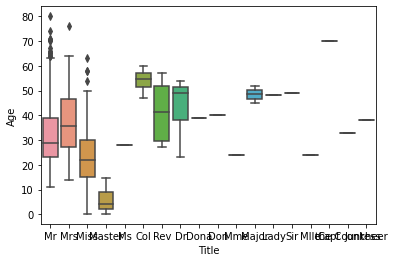

In [107]:
sns.boxplot('Title','Age', data=titanic_df)
print(set(list(titanic_df['Title'])))

title_age = titanic_df.groupby('Title').mean()
title_age.reset_index(inplace=True)
title_age = title_age.loc[:,['Title', 'Age']]
title_age.set_index('Title', inplace=True)

for row, value in titanic_df.iterrows():    
    if np.isnan(value['Age']):
        titanic_df.loc[row, 'Age'] = title_age.loc[value['Title'], 'Age']      

titanic_df.reset_index(inplace=True)
titanic_df.info()


__Embarked__

The null values of the embarked column will be filled with the most common value in the column: S

C:\Users\majac\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        1309 non-null   int64  
 1   PassengerId  1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1309 non-null   object 
 11  Survived     1309 non-null   int64  
 12  Fam_name     1309 non-null   object 
 13  Title        1309 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 143.3+ KB


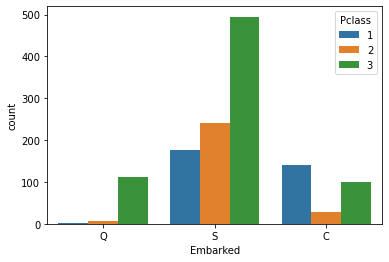

In [108]:
sns.countplot('Embarked', data=titanic_df, hue='Pclass')
titanic_df.groupby('Embarked').count()


titanic_df["Embarked"].fillna("S", inplace = True) 
titanic_df.info()

In [116]:
titanic_df.groupby('Pclass')['Fare'].mean()
titanic_df.loc[titanic_df['Fare'].isnull()]
titanic_df.iloc[152,8] = 13
# # if titanic_df_copy.loc[titanic_df_copy['Fare'].isnull()]:
# #     print('null')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        1309 non-null   int64  
 1   PassengerId  1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1309 non-null   object 
 11  Survived     1309 non-null   int64  
 12  Fam_name     1309 non-null   object 
 13  Title        1309 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 143.3+ KB


__Droping some useless columns__

In [117]:
titanic_df_cop1 = titanic_df.copy()
titanic_df_cop1.drop(columns = ['Cabin', 'index', 'Fam_name'] , inplace=True)
titanic_df_cop1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Sex          1309 non-null   object 
 3   Age          1309 non-null   float64
 4   SibSp        1309 non-null   int64  
 5   Parch        1309 non-null   int64  
 6   Ticket       1309 non-null   object 
 7   Fare         1309 non-null   float64
 8   Embarked     1309 non-null   object 
 9   Survived     1309 non-null   int64  
 10  Title        1309 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 112.6+ KB


__Transforming the type:object column to dummies or continuous categorical data__

1. Sex
2. Embarked
3. Title


In [118]:
sex_dum = pd.get_dummies(titanic_df_cop1['Sex'], drop_first=True)
embarked_dum = pd.get_dummies(titanic_df_cop1['Embarked'], prefix='Embarked:')
titanic_df_cop2 = pd.concat([titanic_df_cop1, sex_dum, embarked_dum], axis=1)
titanic_df_cop2.drop(columns = ['Sex','Embarked'], inplace=True)
titanic_df_cop2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Age          1309 non-null   float64
 3   SibSp        1309 non-null   int64  
 4   Parch        1309 non-null   int64  
 5   Ticket       1309 non-null   object 
 6   Fare         1309 non-null   float64
 7   Survived     1309 non-null   int64  
 8   Title        1309 non-null   object 
 9   male         1309 non-null   uint8  
 10  Embarked:_C  1309 non-null   uint8  
 11  Embarked:_Q  1309 non-null   uint8  
 12  Embarked:_S  1309 non-null   uint8  
dtypes: float64(2), int64(5), object(2), uint8(4)
memory usage: 97.3+ KB


<AxesSubplot:xlabel='Survived', ylabel='count'>

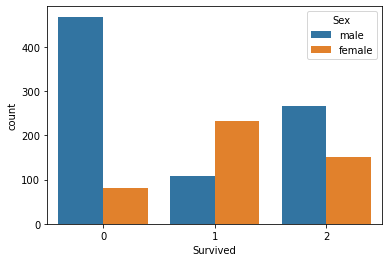

In [119]:
sns.countplot(x = 'Survived', hue='Sex', data = titanic_df_cop1)

In [120]:
titanic_df_cop2['Title'].unique()
titanic_df_cop2.groupby('Title').count()

,PassengerId,Pclass,Age,SibSp,Parch,Ticket,Fare,Survived,male,Embarked:_C,Embarked:_Q,Embarked:_S
Title,,,,,,,,,,,,
Capt,1,1,1,1,1,1,1,1,1,1,1,1
Col,4,4,4,4,4,4,4,4,4,4,4,4
Don,1,1,1,1,1,1,1,1,1,1,1,1
Dona,1,1,1,1,1,1,1,1,1,1,1,1
Dr,8,8,8,8,8,8,8,8,8,8,8,8
Jonkheer,1,1,1,1,1,1,1,1,1,1,1,1
Lady,1,1,1,1,1,1,1,1,1,1,1,1
Major,2,2,2,2,2,2,2,2,2,2,2,2
Master,61,61,61,61,61,61,61,61,61,61,61,61


In [121]:
dict_title = {'Master':'master', 
 'Rev':'Other', 
 'Ms':'Mrs', 
 'Mlle':'miss', 
 'Major':'Other', 
 'Col':'Other', 
 'Capt':'Other', 
 'Mrs':'Mrs', 
 'Don':'Other', 
 'Mme':'Mrs', 
 'the Countess':'Mrs', 
 'Sir':'Mr', 
 'Lady':'Mrs', 
 'Jonkheer':'Other', 
 'Dr':'Mr', 
 'Mr':'Mr', 
 'Miss':'miss',
             'Dona': 'Mrs'}
titanic_df_cop2['Title'] = titanic_df_cop2['Title'].replace(dict_title)

title_dum = pd.get_dummies(titanic_df_cop2['Title'], prefix='Title:')
titanic_df_cop3 = pd.concat([titanic_df_cop2, title_dum], axis=1)
titanic_df_cop3.drop(columns = 'Title', inplace=True)
titanic_df_cop3

,PassengerId,Pclass,Age,SibSp,Parch,Ticket,Fare,Survived,male,Embarked:_C,Embarked:_Q,Embarked:_S,Title:_Mr,Title:_Mrs,Title:_Other,Title:_master,Title:_miss
0,892,3,34.500000,0,0,330911,7.8292,2,1,0,1,0,1,0,0,0,0
1,893,3,47.000000,1,0,363272,7.0000,2,0,0,0,1,0,1,0,0,0
2,894,2,62.000000,0,0,240276,9.6875,2,1,0,1,0,1,0,0,0,0
3,895,3,27.000000,0,0,315154,8.6625,2,1,0,0,1,1,0,0,0,0
4,896,3,22.000000,1,1,3101298,12.2875,2,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,887,2,27.000000,0,0,211536,13.0000,0,1,0,0,1,0,0,1,0,0
1305,888,1,19.000000,0,0,112053,30.0000,1,0,0,0,1,0,0,0,0,1
1306,889,3,21.774238,1,2,W./C. 6607,23.4500,0,0,0,0,1,0,0,0,0,1
1307,890,1,26.000000,0,0,111369,30.0000,1,1,1,0,0,1,0,0,0,0


__Creating new feature__

1. Family status
    0. with parch with sib
    1. with parch no sib
    2. no parch with sib
    3. no parch no sip

2. Age range

In [122]:
for row, value in titanic_df.iterrows():
    if titanic_df_cop3.loc[row, 'Parch'] > 0 and titanic_df_cop3.loc[row, 'SibSp'] > 0:
        titanic_df_cop3.loc[row,'alone'] = 'with parch with sib'
    elif titanic_df_cop3.loc[row, 'Parch']>0 and titanic_df_cop3.loc[row, 'SibSp'] == 0:
        titanic_df_cop3.loc[row,'alone'] = 'with parch no sib'
    elif titanic_df_cop3.loc[row, 'Parch'] == 0 and titanic_df_cop3.loc[row, 'SibSp'] > 0:
        titanic_df_cop3.loc[row,'alone'] = 'no parch with sib'
    elif titanic_df_cop3.loc[row, 'Parch'] == 0 and titanic_df_cop3.loc[row, 'SibSp'] == 0:
        titanic_df_cop3.loc[row,'alone'] = 'no parch no sib'


In [123]:
family_dum = pd.get_dummies(titanic_df_cop3['alone'])
titanic_df_cop4 = pd.concat([titanic_df_cop3, family_dum], axis=1)
titanic_df_cop4.drop(columns = 'alone', inplace=True)
titanic_df_cop4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          1309 non-null   int64  
 1   Pclass               1309 non-null   int64  
 2   Age                  1309 non-null   float64
 3   SibSp                1309 non-null   int64  
 4   Parch                1309 non-null   int64  
 5   Ticket               1309 non-null   object 
 6   Fare                 1309 non-null   float64
 7   Survived             1309 non-null   int64  
 8   male                 1309 non-null   uint8  
 9   Embarked:_C          1309 non-null   uint8  
 10  Embarked:_Q          1309 non-null   uint8  
 11  Embarked:_S          1309 non-null   uint8  
 12  Title:_Mr            1309 non-null   uint8  
 13  Title:_Mrs           1309 non-null   uint8  
 14  Title:_Other         1309 non-null   uint8  
 15  Title:_master        1309 non-null   u

In [124]:
titanic_df_cop4.drop(columns = 'Ticket', inplace=True)

# Machine learning models

In [135]:
test_data = titanic_df_cop4.loc[titanic_df_cop4['Survived']==2]
kaggle_test_titanic = test_data.drop(columns = ['Survived','PassengerId'])
train_data = titanic_df_cop4.loc[titanic_df_cop4['Survived']!=2]

X = train_data.drop(columns = ['Survived','PassengerId'])
y = train_data[['Survived']]

train_data.shape, kaggle_test_titanic.shape

((891, 20), (418, 18))

In [60]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=66)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train_s = sc_x.fit_transform(X_train)
X_test_s = sc_x.transform(X_test)


__1. suport vector machine__

This algorithme works best with scaled data.

In [92]:
from sklearn.svm import SVC
model = SVC(C= 10, gamma= 0.01, kernel= 'rbf')
model.fit(X_train_s,y_train)
pred_SVM = model.predict(X_test_s)
score = model.score(X_test_s, y_test.values.ravel())

## model validation
accuracies = cross_val_score(estimator = clf, X = X_train_s, y = y_train.values.ravel(), cv = 10)
print(accuracies)

score_pred = model.score(X_test_s, y_test)
score_train = model.score(X_train_s, y_train.values.ravel())
print('The score of the prediction is {} \nThe score of the training set is {}'.format(score_pred, score_train))



C:\Users\majac\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0.84722222 0.75       0.90140845 0.73239437 0.70422535 0.87323944
 0.74647887 0.76056338 0.81690141 0.77464789]
The score of the prediction is 0.8435754189944135 
The score of the training set is 0.8384831460674157


In [79]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ['rbf'], 'C':[0.1,0.5,1, 10,100], 'gamma':[0.001, 0.01 ,0.1, 1, 10]}
model = SVC()
grid = GridSearchCV(model,param_grid = parameters,refit=True,verbose=3)
grid.fit(X_train_s, y_train.values.ravel())

print('grid best parameters are: {} and gris beat score is:{}'.format(grid.best_params_ , grid.best_score_))

"""
C=10, gamma=0.001, kernel=rbf
C=0.5, gamma=0.1, kernel=rbf
"""

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.608, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.608, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.613, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.606, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.606, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.832, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.811, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.754, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.761, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.831, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.783, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ............ C=1, gamma=1, kernel=rbf, score=0.783, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.754, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.725, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.810, total=   0.0s
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] ........... C=1, gamma=10, kernel=rbf, score=0.762, total=   0.0s
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] ........... C=1, gamma=10, kernel=rbf, score=0.734, total=   0.0s
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] ........... C=1, gamma=10, kernel=rbf, score=0.662, total=   0.0s
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .

[CV] ......... C=100, gamma=10, kernel=rbf, score=0.690, total=   0.1s
grid best parameters are: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} and gris beat score is:0.8257953314291342


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    6.5s finished


In [98]:
best_grid = grid.best_estimator_
predictions = best_grid.predict(X_test_s)
score_pred = best_grid.score(X_test_s, y_test)
print('The best score is:{}\n The best paramterers are: {}'.format(score_pred, grid.best_estimator_) )

The best score is:0.8435754189944135
 The best paramterers are: SVC(C=10, gamma=0.01)


__2. Logistic regression__

In [72]:
import sklearn.linear_model as sklin
import sklearn.metrics as skmet
clf = sklin.LogisticRegression(random_state=0, max_iter=500, C=5)
clf.fit(X_train_s,y_train)
pred = clf.predict(X_test_s)

## model validation
accuracies = cross_val_score(estimator = clf, X = X_train_s, y = y_train, cv = 10)
print(accuracies)

score_pred = clf.score(X_test_s, y_test)
score_train = clf.score(X_train_s, y_train)
print('The score of the prediction is {} \nThe score of the training set is {}'.format(score_pred, score_train))



C:\Users\majac\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\majac\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\majac\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\majac\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

[0.84722222 0.80555556 0.87323944 0.78873239 0.78873239 0.83098592
 0.8028169  0.8028169  0.87323944 0.84507042]
The score of the prediction is 0.8435754189944135 
The score of the training set is 0.6643258426966292
the score is: 0.8435754189944135


__3. Decision tree classifier__

no need to scale the data

In [70]:
from sklearn import tree
tre = tree.DecisionTreeClassifier()
tre = tre.fit(X_train, y_train)

y_pred = tre.predict(X_test)
score_pred = tre.score(X_test, y_test)
score_train = tre.score(X_train, y_train)
print('The score of the prediction is {} \nThe score of the training set is {}'.format(score_pred, score_train))
tre.get_params()

The score of the prediction is 0.8435754189944135 
The score of the training set is 0.9803370786516854


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [95]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators= 1000, max_depth= 50)
               
clf.fit(X_train, y_train)
score_pred = clf.score(X_test, y_test)
score_train = clf.score(X_train, y_train)
print('The score of the prediction is {} \nThe score of the training set is {}'.format(score_pred, score_train))


C:\Users\majac\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


The score of the prediction is 0.8491620111731844 
The score of the training set is 0.9803370786516854


Randomized search

In [100]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished
C:\Users\majac\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [101]:
best_random = rf_random.best_estimator_
predictions = best_random.predict(X_test)
score_pred = best_random.score(X_test, y_test)
print('the best score is:{}'.format(score_pred))

the best score is:0.8770949720670391


In [102]:
best_random

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=400, random_state=42)

Performing grid search based on the result from the random search: 
Using a range of hyperparameters around the best values returned by random search


In [103]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [70, 80, 90, 100, 110],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2, 3, 4, 5],
    'min_samples_split': [8, 9, 10, 11, 12],
    'n_estimators': [300,400, 500]
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 3, return_train_score=True)

grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
predictions = best_grid.predict(X_test)
score_pred = best_grid.score(X_test, y_test)
print('The best score is:{}\n The best paramterers are: {}'.format(score_pred, grid_search.best_params_) )


Fitting 3 folds for each of 375 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  4.1min finished
C:\Users\majac\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The best score is:0.8770949720670391
 The best paramterers are: {'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 500}


# Ready for submission

RandomForestClassifier(bootstrap=False, max_depth=70, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=12,
                       n_estimators=500, random_state=42)

In [149]:
from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(best_grid)             
arf = best_grid.fit(X, y)
kaggle_predictions =arf.predict(kaggle_test_titanic)

C:\Users\majac\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [151]:
a =kaggle_predictions.tolist()

In [144]:
kaggle_predictions1 = best_grid.predict(kaggle_test_titanic)
len(kaggle_predictions)

418

In [145]:
kaggle_sub = test_data[['PassengerId']]
kaggle_sub['Survived'] = kaggle_predictions.tolist()
kaggle_sub

C:\Users\majac\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [152]:
kaggle_sub['Survived2']=a
kaggle_sub

C:\Users\majac\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PassengerId,Survived,Survived2
0,892,0,0
1,893,0,0
2,894,0,0
3,895,0,0
4,896,1,0
...,...,...,...
413,1305,0,0
414,1306,1,1
415,1307,0,0
416,1308,0,0


In [153]:
kaggle_sub.to_csv(r'C:\Users\majac\Desktop\Titanic Kaggle\titanic_submission2.csv')